In [18]:
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
from tools import *
from implementations import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
seed = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [2]:
DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'

In [3]:
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Density plots of the features

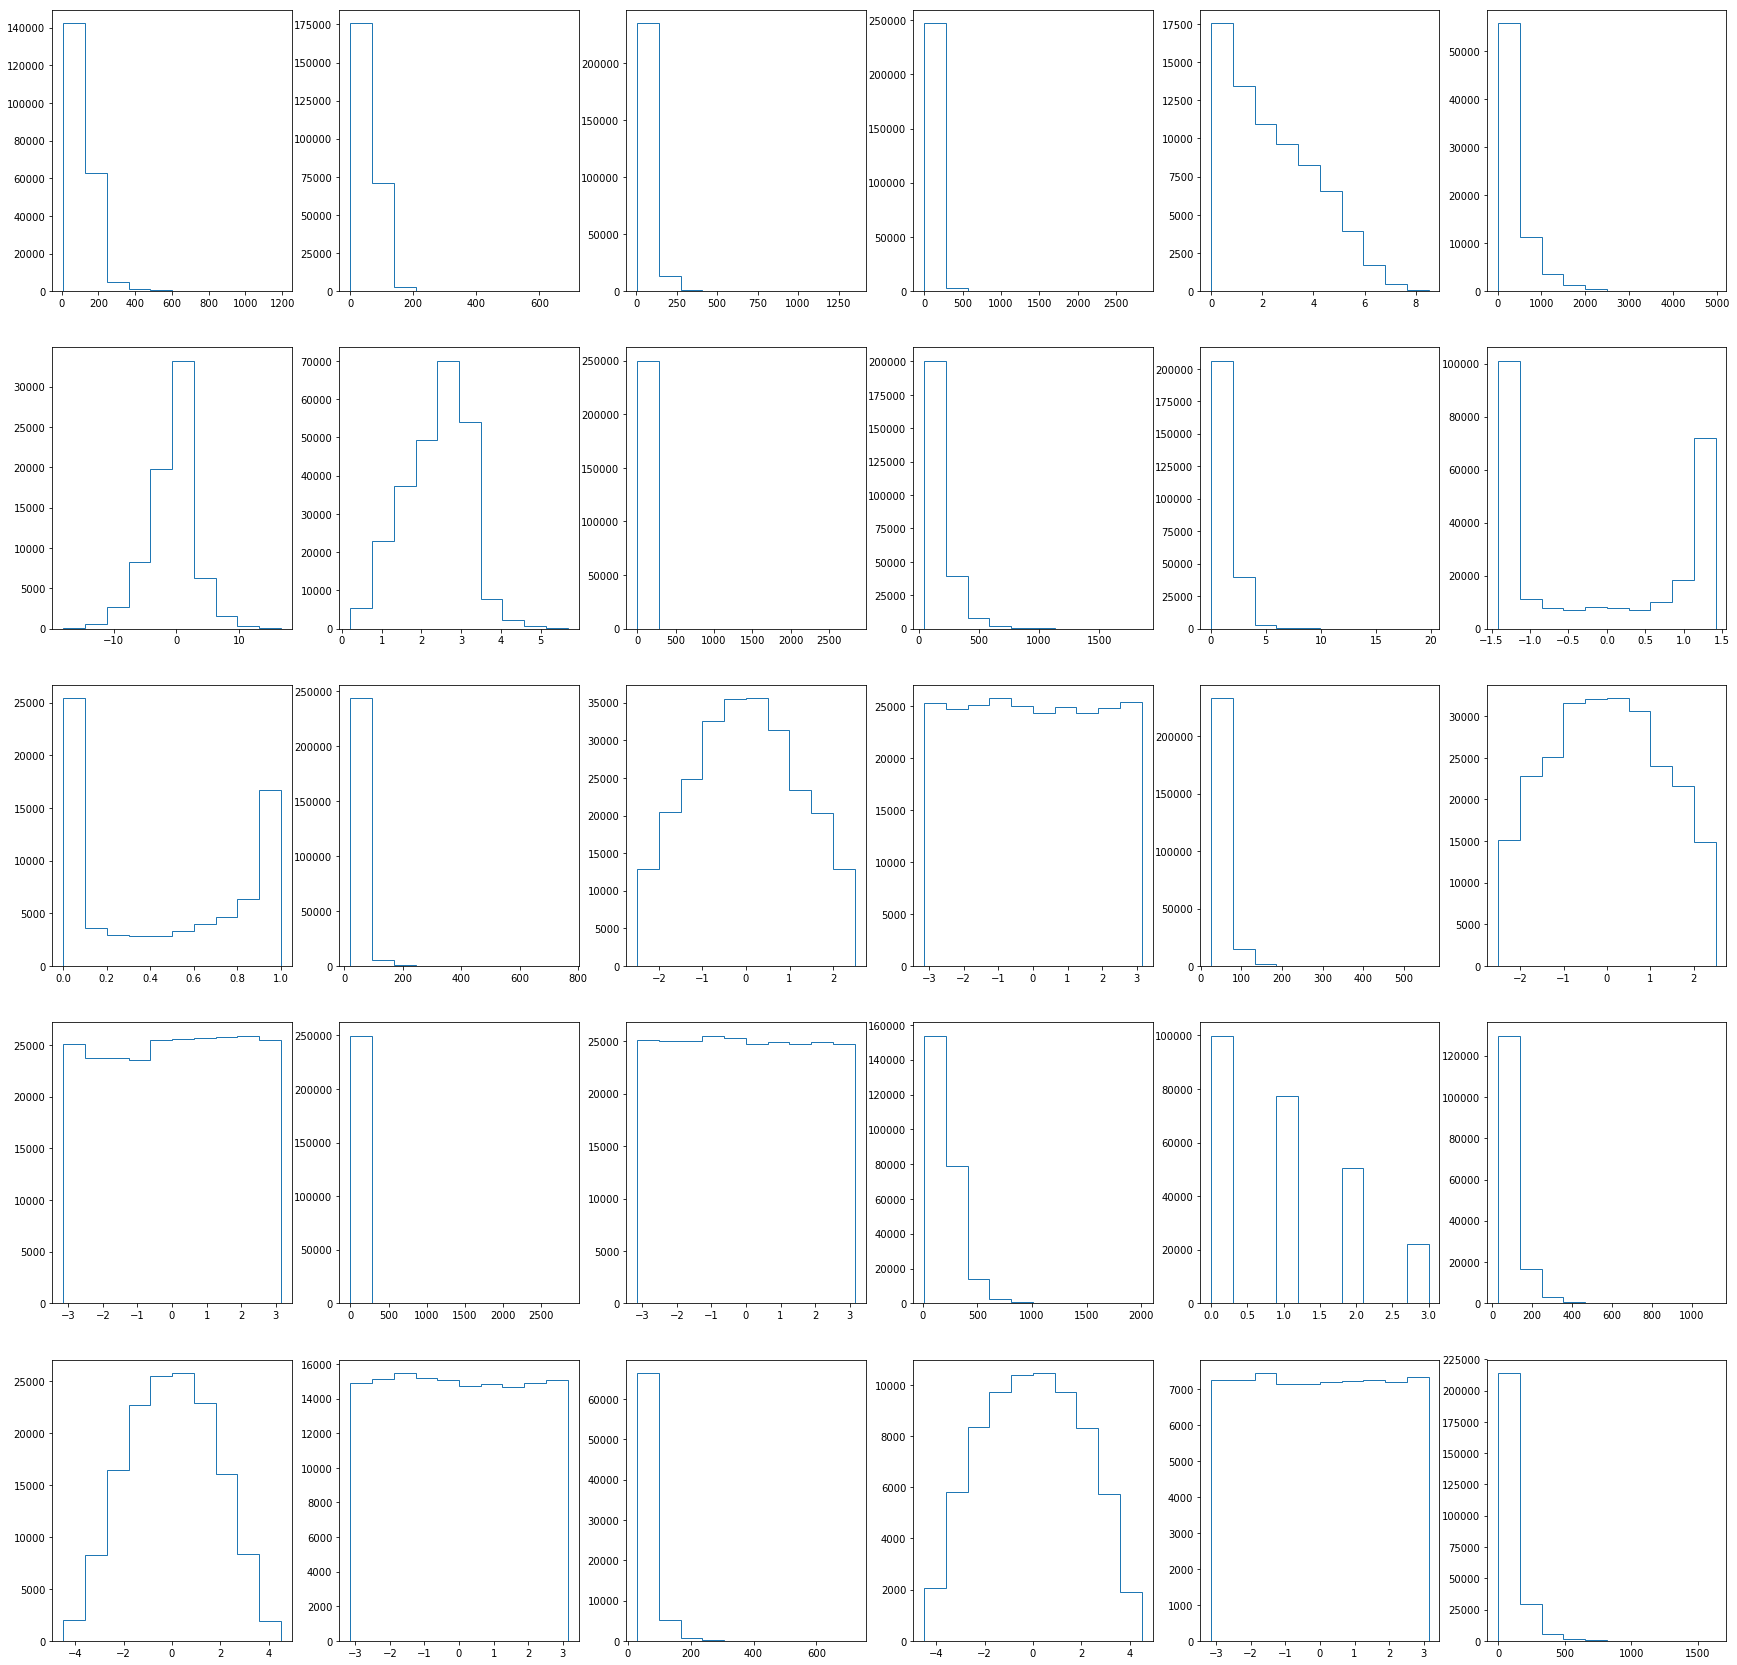

In [33]:
num_features = np.shape(tX)[1] 
_,a = plt.subplots(5,6,figsize = (30,30))
a = a.ravel()
for i,temp in enumerate(a):
    column = tX[:,i]
    temp_data = column[np.where(column != -999)]
    temp.hist(temp_data,histtype = 'step')

### 5 Phi features

From the density plots of all the 30 features above, we can easily found that there are 5 features whose plots are very different from the others. After checking the name of these features by index, we found that all of them are Phi variables. These Phi variables showed uniform densities indicating that these features are not very useful for the prediction. We can drop these variables without any loss of fidelity against the information from the original data set.

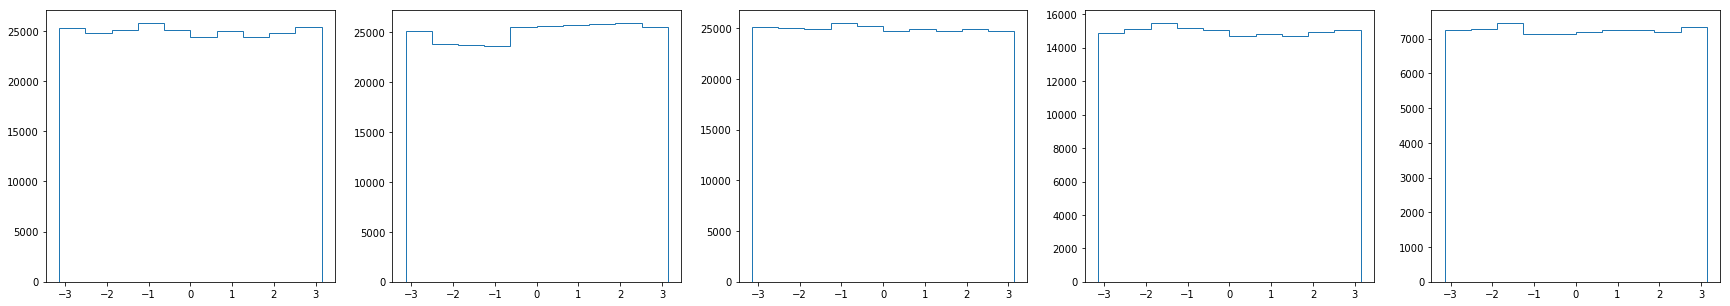

In [32]:
phi_features_index = [15,18,20,25,28]
_,a = plt.subplots(1,5,figsize = (30,5))
a = a.ravel()
for i,temp in enumerate(a):
    column = tX[:,phi_features_index[i]]
    temp_data = column[np.where(column != -999)]
    temp.hist(temp_data,histtype = 'step')

### Data processing

For data processing, we decided to replaced -999 by the most frequent value of the column if there exists at least one non -999 value in the column. Otherwise, by 0 which means we deleted this feature. Then, we implemented the logorithm inverse to all the positive columns in order to reduce the range of the values. Finally, we standardize the whole dataset by subtract the mean and divide by the standard deviation for each feature.

In [27]:
def replace_missing_data_by_frequent_value(x_train, x_test):
    for i in range(x_train.shape[1]):
        if np.any(x_train[:, i] == -999):
            temp_train = (x_train[:, i] != -999) #return a list of true or false
            temp_test = (x_test[:, i] != -999)
            values, counts = np.unique(x_train[temp_train, i], return_counts = True)
            if (len(values) > 1):
                x_train[~temp_train, i] = values[np.argmax(counts)]
                x_test[~temp_test, i] = values[np.argmax(counts)]
            else:
                x_train[~temp_train, i] = 0
                x_test[~temp_test, i] = 0
    return x_train, x_test

In [26]:
def process_data(x_train, x_test):
    x_train, x_test = replace_missing_data_by_frequent_value(x_train, x_test)

    log_cols_index = [0, 1, 2, 5, 7, 9, 10, 13, 16, 19, 21, 23, 26]
    x_train_log_cols_index = np.log(1 / (1 + x_train[:, log_cols_index]))
    x_train = np.hstack((x_train, x_train_log_cols_index))
    x_test_log_cols_index = np.log(1 / (1 + x_test[:, log_cols_index]))
    x_test = np.hstack((x_test, x_test_log_cols_index))

    x_train, mean_train, std_train = standardize(x_train)
    x_test, mean_test, std_test = standardize(x_test, mean_train, std_train)

    x_train = np.delete(x_train, [15,18,20,25,28], 1)
    x_test = np.delete(x_test, [15,18,20,25,28], 1)

    return x_train, x_test

## Cross validation

In [9]:
def cross_validation(y, x, k_indices, k, regression_method, **kwargs):
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)

    y_test = y[test_indice]
    y_train = y[train_indice]
    x_test = x[test_indice]
    x_train = x[train_indice]

    # Data processing
    x_train, x_test = process_data(x_train, x_test)
    # Add constant column
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

    weight, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)

    y_train_pred = predict_labels(weight, x_train)
    y_test_pred = predict_labels(weight, x_test)

    accuracy_train = compute_accuracy(y_train_pred, y_train)
    accuracy_test = compute_accuracy(y_test_pred, y_test)

    return accuracy_train, accuracy_test

In [10]:
def cross_validation_split_data_by_jet_no(y, x, k_indices, k, lambdas, degrees):
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)

    all_y_test = y[test_indice]
    all_y_train = y[train_indice]
    all_x_test = x[test_indice]
    all_x_train = x[train_indice]

    # Split data into three subset by jet_no
    dict_jets_train = group_features_by_jet(all_x_train)
    dict_jets_test = group_features_by_jet(all_x_test)

    y_train_pred = np.zeros(len(all_y_train))
    y_test_pred = np.zeros(len(all_y_test))

    for index in range(len(dict_jets_train)):
        x_train = all_x_train[dict_jets_train[index]]
        x_test = all_x_test[dict_jets_test[index]]
        y_train = all_y_train[dict_jets_train[index]]

        # Data processing
        x_train, x_test = process_data(x_train, x_test)
        # Build polynomial features
        x_train = build_polynomial_features(x_train, degrees[index])
        x_test = build_polynomial_features(x_test, degrees[index])
        # Add constant column 
        x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

        weight, loss_train = ridge_regression(y = y_train, tx = x_train, lambda_ = lambdas[index])

        y_train_pred[dict_jets_train[index]] = predict_labels(weight, x_train)
        y_test_pred[dict_jets_test[index]] = predict_labels(weight, x_test)

    accuracy_train = compute_accuracy(y_train_pred, all_y_train)
    accuracy_test = compute_accuracy(y_test_pred, all_y_test)

    return accuracy_train, accuracy_test

## Gradient descent

In [7]:
k_fold = 5
gamma = 0.01
max_iters = 500
k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, least_squares_gd, initial_w = None, max_iters = max_iters, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
    
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0 - Test accuracy : 0.75853
Training accuracy: 1 - Test accuracy : 0.75843
Training accuracy: 2 - Test accuracy : 0.75819
Training accuracy: 3 - Test accuracy : 0.757445
Training accuracy: 4 - Test accuracy : 0.758455
Average test accuracy: 0.7579839999999999
Variance test accuracy: 3.344863999999969e-06


## Stochastic gradient descent

In [8]:
k_fold = 5
gamma = 0.1
max_iters = 500
k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, least_squares_sgd, initial_w = None, max_iters = max_iters, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("{}: Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

0: Training accuracy: 0.4139 - Test accuracy : 0.41642
1: Training accuracy: 0.456255 - Test accuracy : 0.45802
2: Training accuracy: 0.63485 - Test accuracy : 0.63156
3: Training accuracy: 0.546485 - Test accuracy : 0.54686
4: Training accuracy: 0.60243 - Test accuracy : 0.60274
Average test accuracy: 0.5311199999999999
Variance test accuracy: 0.006793013120000002


## Least squares

In [24]:
k_fold = 5
k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, least_squares)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("{}: Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

0: Training accuracy: 0.7753 - Test accuracy : 0.77166
1: Training accuracy: 0.77587 - Test accuracy : 0.7757
2: Training accuracy: 0.774895 - Test accuracy : 0.77594
3: Training accuracy: 0.77425 - Test accuracy : 0.77394
4: Training accuracy: 0.775435 - Test accuracy : 0.77788
Average test accuracy: 0.7750239999999999
Variance test accuracy: 4.388863999999989e-06


## Ridge regression

In [23]:
k_fold = 2
lambda_ = 0.0001
k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, ridge_regression, lambda_ = lambda_)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("{}: Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

0: Training accuracy: 0.776216 - Test accuracy : 0.775376
1: Training accuracy: 0.775104 - Test accuracy : 0.775976
Average test accuracy: 0.775676
Variance test accuracy: 9.000000000001348e-08


## Logistic regression

In [148]:
k_fold = 2
gamma = 0.01
max_iters = 1000
k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, logistic_regression, initial_w = None ,max_iters = max_iters, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("{}: Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

0: Training accuracy: 0.725848 - Test accuracy : 0.726168
1: Training accuracy: 0.727192 - Test accuracy : 0.726472
Average test accuracy: 0.7263200000000001
Variance test accuracy: 2.3103999999995586e-08


## Regularized Logistic Regression

In [28]:
k_fold = 2
gamma = 0.01
max_iters = 1000
lambda_ = 0.0001
k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, regularized_logistic_regression, initial_w = None ,max_iters = max_iters, lambda_=lambda_, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("{}: Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

0: Training accuracy: 0.725848 - Test accuracy : 0.726168
1: Training accuracy: 0.727192 - Test accuracy : 0.726472
Average test accuracy: 0.7263200000000001
Variance test accuracy: 2.3103999999995586e-08


## Ridge regression + Split data by jet_no

In [15]:
k_fold = 2
lambdas = [0.0001, 0.0001, 0.0001]
degrees = [12, 13, 10]
k_indices = build_k_indices(y, k_fold, seed)

list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    accuracy_train, accuracy_test = cross_validation_split_data_by_jet_no(y, tX, k_indices, k, lambdas, degrees)
    list_accuracy_train.append(accuracy_train)
    list_accuracy_test.append(accuracy_test)

for i in range(len(list_accuracy_train)):
    print("{}: Training accuracy: {} - Test accuracy : {}".format(i, list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

0: Training accuracy: 0.839552 - Test accuracy : 0.8356
1: Training accuracy: 0.842456 - Test accuracy : 0.837256
Average test accuracy: 0.836428
Variance test accuracy: 6.855839999999924e-07


## Generate the best prediction

In [9]:
print('Start predicting...\n')

DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'

y_train, tx_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
_, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

lambdas = [0.0001, 0.0001, 0.0001]
degrees = [12, 13, 10]

y_pred = np.zeros(tx_test.shape[0])

dict_jets_train = group_features_by_jet(tx_train)
dict_jets_test = group_features_by_jet(tx_test)

print('Start training...\n')

for index in range(len(dict_jets_train)):
    x_train = tx_train[dict_jets_train[index]]
    x_test = tx_test[dict_jets_test[index]]
    y_train = y[dict_jets_train[index]]

    # Data processing
    x_train, x_test = process_data(x_train, x_test)
    # Build polynomial features
    x_train = build_polynomial_features(x_train, degrees[index])
    x_test = build_polynomial_features(x_test, degrees[index])
    # Add consant column
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

    weight, loss_train = ridge_regression(y_train, x_train, lambdas[index])

    temp_test_pred = predict_labels(weight, x_test)

    y_pred[dict_jets_test[index]] = temp_test_pred
    
print('Start generating prediction files...\n')

OUTPUT_PATH = 'data/output_ridge_regression.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

print('Finish!')


Start predicting...

Start generating prediction files...

Finish!
